<a href="https://colab.research.google.com/github/kris15putrach/NiHaO/blob/master/UNet_Segmentasi_Penyakit_Tanaman_Kentang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools opencv-python tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, cv2, json, numpy as np, shutil
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Potato_Segmentation_Project/'
ANNOTATION_FILE = BASE_PATH + 'coco_dataset/annotations/annotations.json'
IMAGE_DIR = BASE_PATH + 'coco_dataset/images/'
MASK_DIR = BASE_PATH + 'masks/'
DATASET_DIR = BASE_PATH + 'dataset/'

os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


In [ ]:
coco = COCO(ANNOTATION_FILE)
for img_id in tqdm(coco.getImgIds(), desc="Generating masks"):
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    height, width = img_info['height'], img_info['width']

    mask = np.zeros((height, width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann['category_id']
        segmentation = coco.annToMask(ann)
        mask[segmentation == 1] = cat_id

    cv2.imwrite(os.path.join(MASK_DIR, file_name.replace('.jpg', '.png')), mask)


loading annotations into memory...
Done (t=1.42s)
creating index...
index created!


Generating masks: 100%|██████████| 794/794 [04:58<00:00,  2.66it/s]


In [ ]:
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg') and os.path.exists(os.path.join(MASK_DIR, f.replace('.jpg', '.png')))]

train_files, testval_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

splits = {'train': train_files, 'val': val_files, 'test': test_files}

for split, files in splits.items():
    for subfolder in ['images', 'masks']:
        os.makedirs(os.path.join(DATASET_DIR, split, subfolder), exist_ok=True)
    for file in files:
        shutil.copy(os.path.join(IMAGE_DIR, file), os.path.join(DATASET_DIR, split, 'images', file))
        shutil.copy(os.path.join(MASK_DIR, file.replace('.jpg', '.png')), os.path.join(DATASET_DIR, split, 'masks', file.replace('.jpg', '.png')))


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256,256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(image_dir)
        self.img_size = img_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '.png'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = image.astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        mask[mask > 3] = 0

        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.upconv3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)


In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 --force-reinstall
!pip install sympy==1.11.1 --force-reinstall


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 4
EPOCHS = 50

train_dataset = SegmentationDataset(DATASET_DIR+'train/images/', DATASET_DIR+'train/masks/')
val_dataset = SegmentationDataset(DATASET_DIR+'val/images/', DATASET_DIR+'val/masks/')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

model = UNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_pixels = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == masks).sum().item()
        total_pixels += masks.numel()

    acc = total_correct / total_pixels
    losses.append(total_loss/len(train_loader))
    accuracies.append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc*100:.2f}%")


Epoch 1/50, Loss: 0.6481, Accuracy: 79.83%
Epoch 2/50, Loss: 0.4983, Accuracy: 82.94%
Epoch 3/50, Loss: 0.4388, Accuracy: 84.46%
Epoch 4/50, Loss: 0.4022, Accuracy: 85.54%
Epoch 5/50, Loss: 0.3648, Accuracy: 86.49%
Epoch 6/50, Loss: 0.3463, Accuracy: 86.98%
Epoch 7/50, Loss: 0.3200, Accuracy: 87.92%
Epoch 8/50, Loss: 0.3115, Accuracy: 88.18%
Epoch 9/50, Loss: 0.2974, Accuracy: 88.72%
Epoch 10/50, Loss: 0.2895, Accuracy: 88.99%
Epoch 11/50, Loss: 0.2762, Accuracy: 89.24%
Epoch 12/50, Loss: 0.2700, Accuracy: 89.36%
Epoch 13/50, Loss: 0.2729, Accuracy: 89.48%
Epoch 14/50, Loss: 0.2574, Accuracy: 89.87%
Epoch 15/50, Loss: 0.2493, Accuracy: 90.25%
Epoch 16/50, Loss: 0.2401, Accuracy: 90.69%
Epoch 17/50, Loss: 0.2365, Accuracy: 90.85%
Epoch 18/50, Loss: 0.2345, Accuracy: 90.60%
Epoch 19/50, Loss: 0.2218, Accuracy: 91.14%
Epoch 20/50, Loss: 0.2232, Accuracy: 91.03%
Epoch 21/50, Loss: 0.2178, Accuracy: 91.26%
Epoch 22/50, Loss: 0.2162, Accuracy: 91.61%
Epoch 23/50, Loss: 0.1994, Accuracy: 92.0

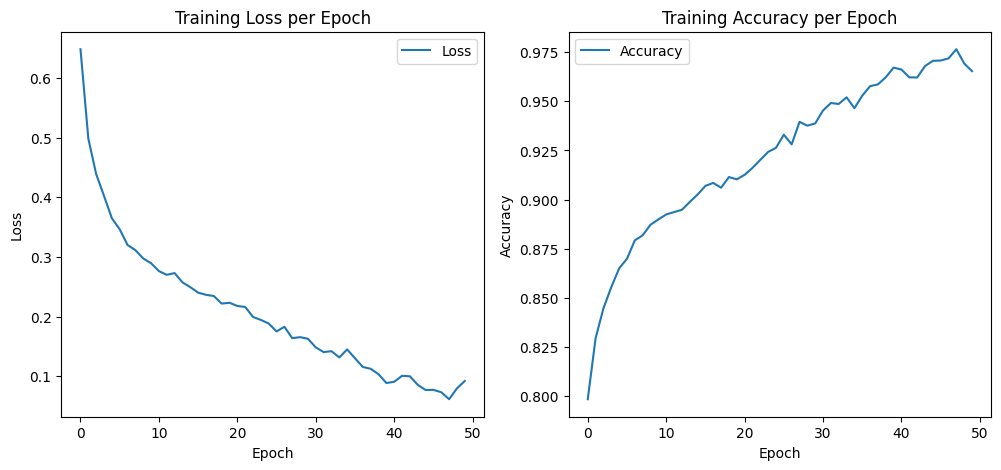

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses, label='Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


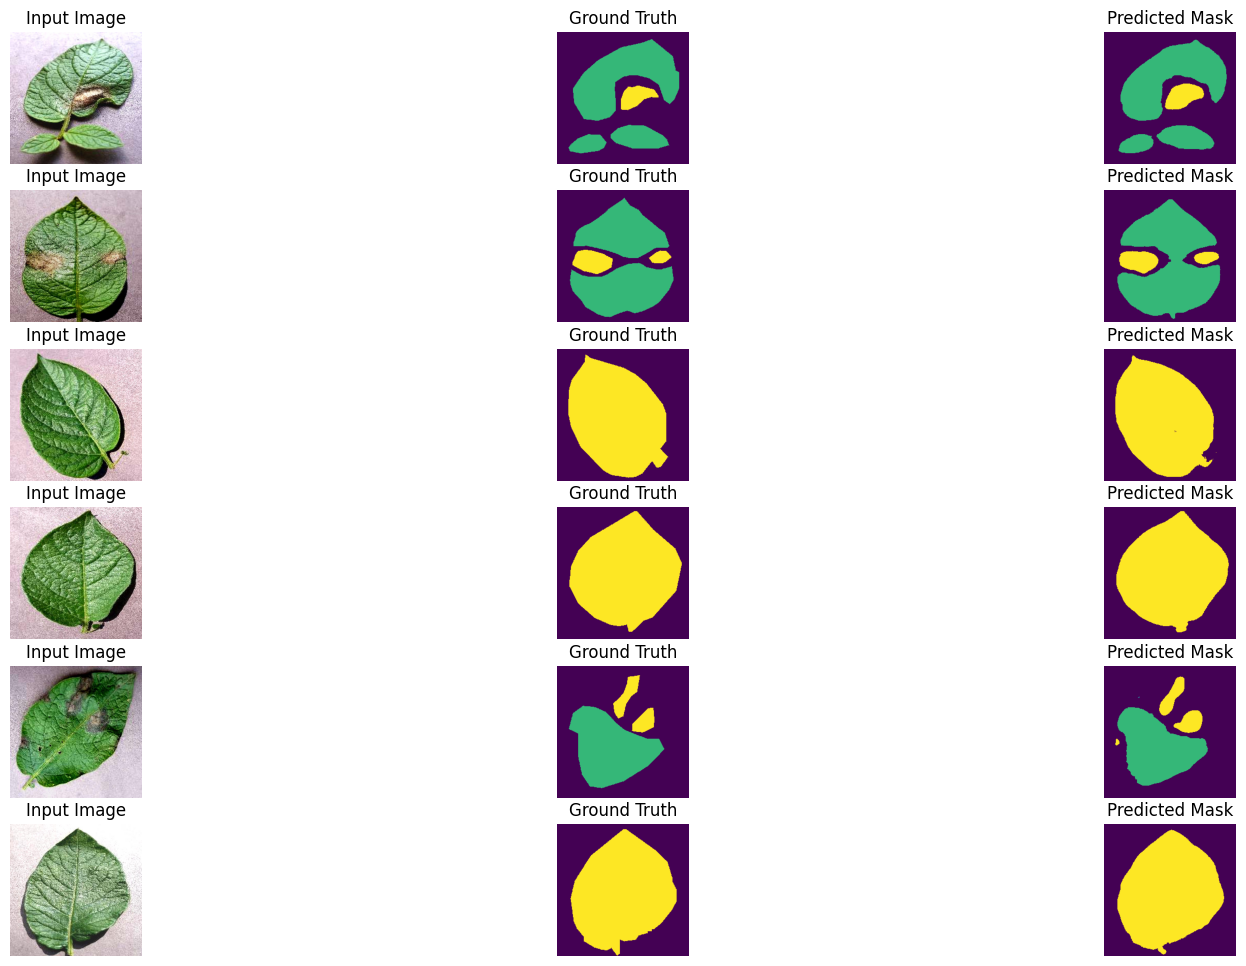

In [ ]:
model.eval()
sample_loader = DataLoader(val_dataset, batch_size=6, shuffle=True)
images, masks = next(iter(sample_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)

plt.figure(figsize=(20, 12))
for i in range(6):
    plt.subplot(6, 3, i*3+1)
    plt.imshow(images[i].permute(1,2,0).cpu().numpy())
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(6, 3, i*3+2)
    plt.imshow(masks[i].cpu().numpy())
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(6, 3, i*3+3)
    plt.imshow(preds[i].cpu().numpy())
    plt.title('Predicted Mask')
    plt.axis('off')
plt.show()
